<a href="https://colab.research.google.com/github/honeyshi/NLP_Lab1/blob/main/NLP_Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [54]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim

import copy

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob

from string import punctuation

from collections import Counter

import keras
import keras.layers as L
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import LatentDirichletAllocation, PCA

from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.palettes import Spectral5
from bokeh.transform import factor_cmap
import bokeh.models as bm, bokeh.plotting as pl

from wordcloud import WordCloud

import plotly.express as px

In [ ]:
pip install catboost

In [154]:
from catboost import CatBoostClassifier

In [ ]:
pip install pyLDAvis

In [ ]:
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis

In [24]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

In [7]:
train = pd.read_parquet('/content/drive/My Drive/data/train.parquet')
train = train.reset_index()

## Exploratory Data Analysis

In [8]:
def remove_html_brackets(body):
  return body.replace("<", "").replace(">", " ").strip()

In [9]:
train['Tags'] = train['Tags'].apply(remove_html_brackets)

In [5]:
train.head()

,Id,Body,Tags,Title,target
0,34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,java algorithm graph-algorithm,I am implementing a Minimum Spanning Forrest a...,2
1,47303682,"While converting the data frame to HTML, Date ...",html r dataframe,"R Studio: Date is getting converted to number,...",2
2,46431243,"<p>This should be an easy one, but somehow I c...",python pandas dataframe pandas-groupby,Pandas - dataframe groupby - how to get sum of...,0
3,45306324,<p>Let say I have a component in Angular 2 tha...,angular typescript rxjs,Casting results from Observable.forkJoin to th...,0
4,49479547,<p>I'm setting a var using \n<code>set TEST_VA...,c windows batch-file,Environment variable set in batch file cannot ...,1


In [10]:
train['Tags_list'] = train['Tags'].apply(lambda x: x.split())
all_tags = [item for sublist in train['Tags_list'].values for item in sublist]

In [11]:
unique_tags = list(set(all_tags))

In [8]:
print("Length all tags: %d Length unique tags: %d" % (len(all_tags), len(unique_tags)))

Length all tags: 127809 Length unique tags: 9619


In [180]:
frequency_dict = nltk.FreqDist(all_tags)

most_common_words = frequency_dict.most_common(10)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


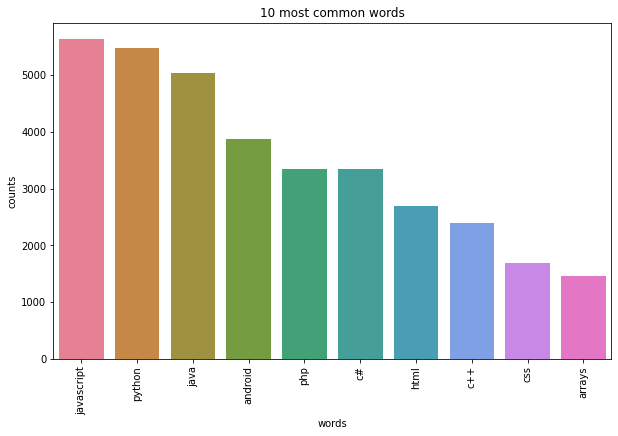

In [132]:
words = [w[0] for w in most_common_words]
counts = [w[1] for w in most_common_words]
x_pos = np.arange(len(words)) 
    
plt.figure(2, figsize=(10, 10/1.6180))
plt.subplot(title='10 most common words')
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.barplot(x_pos, counts, palette='husl')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('words')
plt.ylabel('counts')
plt.show()

In [12]:
output_notebook()

In [13]:
average_length = {}
avergae_count = {}
count_quality = {}
for i, item in train.iterrows():
  for tag in item["Tags_list"]:
    avergae_count[tag] = avergae_count.get(tag, 0)+1
    average_length[tag] = average_length.get(tag, 0) + len(item["Body"])
    if tag not in count_quality:
      count_quality[tag] = []
    count_quality[tag].append(item["target"])
    


new_data = {}
for key in avergae_count:
  new_data[key] = {
      "avg_len": 0,
      "count": 0
  }  
  new_data[key]["avg_len"] = average_length[key]/avergae_count[key]
  new_data[key]["count"] = avergae_count[key]

In [14]:
avg_qua = pd.DataFrame({}, columns=['tag', '0', '1', '2', 'target_count'])
for item in count_quality:
  s={'tag': item,'0':0, '1':0, '2':0, 'target_count': 0}
  for i in count_quality[item]:
    s[str(i)]+=1
  s['target_count']=s['0']+s['1']+s['2']
  avg_qua= pd.concat([avg_qua, pd.DataFrame(s, index=[0])])
avg_qua=avg_qua.sort_values(by="target_count",ascending=0)

In [15]:
targets = ['0', '1', '2']
count = 30
data = {
    "target": targets,
    "0": [],
    "1": [],
    "2": []
}
for i, item in avg_qua[:count].iterrows():
  data[item["tag"]] = []
  data["0"].append(item["0"])
  data["1"].append(item["1"])
  data["2"].append(item["2"])
print(data)

x = [ (tag["tag"], target) for i, tag in avg_qua[:count].iterrows() for target in targets ]
counts = sum(zip(data["0"], data['1'], data['2']), ()) # like an hstack

source = ColumnDataSource(data=dict(x=x, counts=counts))

p = figure(x_range=FactorRange(*x), plot_height=400, plot_width=1600, title="Кол-во оценок для "+ str(count) +" самых встречающихся тегов",
           toolbar_location=None, tools="")

p.vbar(x='x', top='counts', width=0.9, source=source,
       fill_color=factor_cmap('x', palette=Spectral5, factors=targets, start=1, end=2))

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None

show(p)

{'target': ['0', '1', '2'], '0': [1540, 1596, 849, 1368, 323, 595, 280, 458, 242, 113, 690, 118, 68, 67, 132, 469, 913, 203, 776, 226, 38, 56, 536, 51, 151, 564, 127, 21, 457, 44], '1': [2349, 2082, 2252, 966, 1815, 1455, 1296, 1199, 797, 700, 336, 666, 782, 318, 552, 361, 129, 415, 99, 434, 506, 125, 164, 404, 269, 60, 267, 99, 12, 213], '2': [1749, 1802, 1930, 1546, 1217, 1297, 1118, 730, 653, 655, 425, 664, 597, 935, 573, 422, 151, 477, 73, 254, 363, 673, 133, 343, 354, 55, 143, 386, 18, 211], 'javascript': [], 'python': [], 'java': [], 'android': [], 'php': [], 'c#': [], 'html': [], 'c++': [], 'css': [], 'arrays': [], 'ios': [], 'jquery': [], 'c': [], 'sql': [], 'mysql': [], 'swift': [], 'angular': [], 'python-3.x': [], 'reactjs': [], 'r': [], 'regex': [], 'sql-server': [], 'node.js': [], 'string': [], 'json': [], 'typescript': [], 'linux': [], 'excel': [], 'docker': [], 'list': []}


Самое большое количество вопросов с высокой оценкой имеют теги, связанные с фреймворками для веб разработки. Скорее всего, в этой сфере не так много новичков в программировании, которые могли бы задавать глупые вопросы, а специалисты задают более точные и полезные вопросы. По вопросами с тегами sql и sql-server неотвеченных вопросов намного больше, чем закрытых или решенных. Также много хороших вопросов задается по ios разработке. По тегу `docker` можно сказать практически нет плохих вопросов. Оценка вопросов может зависеть от уровня программистов, работающих на этом языке программирования или с этой технологией.

In [16]:
from itertools import islice
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [17]:
new_data = {k: v for k, v in sorted(new_data.items(), key=lambda item: -item[1]["count"])}

In [18]:
targets = ['avg_len', 'tag_count']
count = 30
data = {
    "target": targets,
    "avg_len": [],
    "tag_count": []
}
for i, item in take(count, new_data.items()):
  data["avg_len"].append(item["avg_len"])
  data["tag_count"].append(avergae_count[i])

x = [ (i , target) for i, tag in take(count, new_data.items()) for target in targets ]
counts = sum(zip(data["avg_len"], data['tag_count']), ()) # like an hstack

source = ColumnDataSource(data=dict(x=x, counts=counts))

p = figure(x_range=FactorRange(*x), plot_height=400, plot_width=1600, title="Средняя длина вопроса и кол-во вопросов с тегом из "+ str(count) +" самых встречающихся тегов",
           toolbar_location=None, tools="")

p.vbar(x='x', top='counts', width=0.9, source=source,
       fill_color=factor_cmap('x', palette=Spectral5, factors=targets, start=1, end=2))

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None

show(p)

Вопросы, относящие к популярным тегам, имеют небольшую среднюю длину. Вопросы по менее популярным тегам сравнительно более длинные. Примечательна средняя длина вопросов по тегу `docker`. Это сравнительно новая технология, поэтому, скорее всего, у людей возникает с ней много проблем, что порождает появление длинных вопросов.

In [133]:
top_30_tags = [word[0] for word in frequency_dict.most_common(30)]

In [134]:
def create_new_features(data):
  data['Tags_count'] = data['Tags_list'].apply(lambda x: len([tag for tag in x]))
  data['Title_words_count'] = data['Title'].apply(lambda x: len(str(x).split()))
  data['Body_words_count'] = data['Body'].apply(lambda x: len(str(x).split()))
  data['Title_chars_count'] = data['Title'].apply(lambda x: sum(len(word) for word in str(x).split()))
  data['Body_chars_count'] = data['Body'].apply(lambda x: sum(len(word) for word in str(x).split()))
  data['Title_sentence_count'] = data['Title'].apply(lambda x: len(str(x).split(".")))
  data['Body_sentence_count'] = data['Body'].apply(lambda x: len(str(x).split(".")))
  data['Title_avg_word_length'] = data['Title_chars_count'] / data['Title_words_count']
  data['Body_avg_word_length'] = data['Body_chars_count'] / data['Body_words_count']
  data['Title_avg_sentence_length'] = data['Title_words_count'] / data['Title_sentence_count']
  data['Body_avg_sentence_length'] = data['Body_words_count'] / data['Body_sentence_count']
  data['Body_sentiment'] = data['Body'].apply(lambda x: TextBlob(x).sentiment.polarity)
  data['Title_punct_count'] = data['Title'].apply(lambda x: len([char for char in x if char in punctuation]))
  data['Body_punct_count'] = data['Body'].apply(lambda x: len([char for char in x if char in punctuation]))
  data['Body_exclamation_count'] =data['Body'].apply(lambda x: x.count('!'))
  data['Body_question_count'] = data['Body'].apply(lambda x: x.count('?'))
  data['Body_unique_words_count'] = data['Body'].apply(lambda x: len(set(word for word in str(x).split())))

  data['Contains_top_tags'] = ''
  for index, row in data.iterrows(): 
    flag = False
    for tag in row['Tags_list']:
      if tag in top_30_tags:
        data.at[index, "Contains_top_tags"] = 1
        flag = True
      else:
        if flag == False:
          data.at[index, "Contains_top_tags"] = 0

In [135]:
train_with_features = copy.deepcopy(train)

In [136]:
create_new_features(train_with_features)

In [137]:
train_with_features.head()

,Id,Body,Tags,Title,target,Tags_list,Tags_count,Title_words_count,Body_words_count,Title_chars_count,Body_chars_count,Title_sentence_count,Body_sentence_count,Title_avg_word_length,Body_avg_word_length,Title_avg_sentence_length,Body_avg_sentence_length,Body_sentiment,Title_punct_count,Body_punct_count,Body_exclamation_count,Body_question_count,Body_unique_words_count,Contains_top_tags
0,34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,java algorithm graph-algorithm,I am implementing a Minimum Spanning Forrest a...,2,"[java, algorithm, graph-algorithm]",3,18,98,78,383,2,5,4.333333,3.908163,9.0,19.600000,-0.049107,1,29,0,0,70,1
1,47303682,"While converting the data frame to HTML, Date ...",html r dataframe,"R Studio: Date is getting converted to number,...",2,"[html, r, dataframe]",3,13,20,65,86,1,2,5.000000,4.300000,13.0,10.000000,0.000000,2,3,0,1,18,1
2,46431243,"<p>This should be an easy one, but somehow I c...",python pandas dataframe pandas-groupby,Pandas - dataframe groupby - how to get sum of...,0,"[python, pandas, dataframe, pandas-groupby]",4,12,194,52,896,1,12,4.333333,4.618557,12.0,16.166667,0.147222,2,146,0,0,113,1
3,45306324,<p>Let say I have a component in Angular 2 tha...,angular typescript rxjs,Casting results from Observable.forkJoin to th...,0,"[angular, typescript, rxjs]",3,11,184,69,1392,2,31,6.272727,7.565217,5.5,5.935484,0.143750,1,203,0,1,125,1
4,49479547,<p>I'm setting a var using \n<code>set TEST_VA...,c windows batch-file,Environment variable set in batch file cannot ...,1,"[c, windows, batch-file]",3,17,24,76,138,1,3,4.470588,5.750000,17.0,8.000000,0.000000,0,17,0,0,22,1


In [138]:
def plot_average_body_sentiment_for_tags(data):
  body_sentiment_dict = {key: 0 for key in top_30_tags}
  tag_count_dict = {key: 0 for key in top_30_tags}
  for index, row in data.iterrows(): 
    for tag in row['Tags_list']:
      if tag in top_30_tags:
        body_sentiment_dict[tag] += row['Body_sentiment']
        tag_count_dict[tag] += 1
  
  for key, value in body_sentiment_dict.items():
    body_sentiment_dict[key] = body_sentiment_dict[key] / tag_count_dict[key]

  tags = list(body_sentiment_dict.keys())
  average_sentiment = list(body_sentiment_dict.values())
  x_pos = np.arange(len(tags)) 
      
  plt.figure(2, figsize=(20, 10/1.6180))
  plt.subplot(title='Average Body sentiment for top 30 tags')
  sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
  sns.barplot(x_pos, average_sentiment, palette='husl')
  plt.xticks(x_pos, tags, rotation=90) 
  plt.xlabel('Tags')
  plt.ylabel('Average sentiment')
  plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


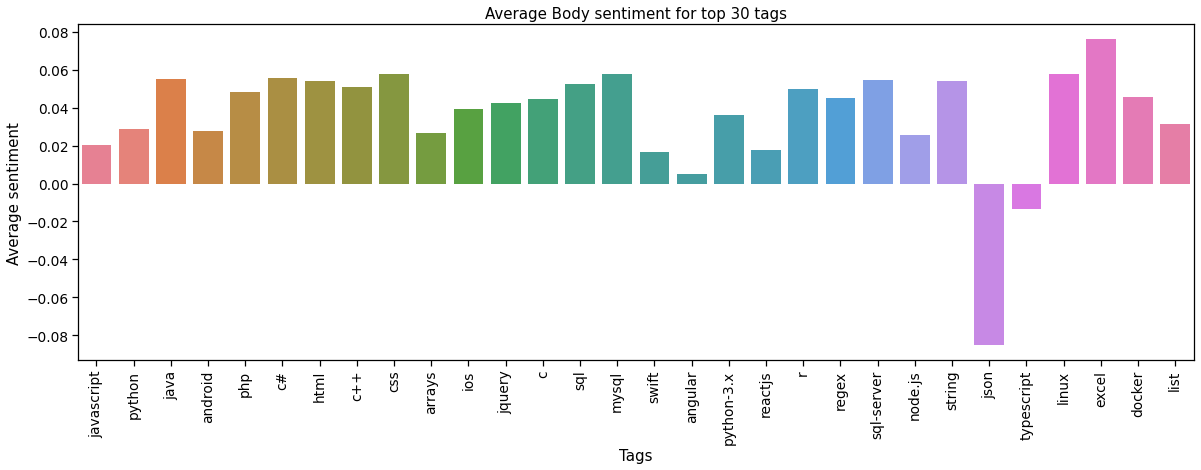

In [139]:
plot_average_body_sentiment_for_tags(train_with_features)

В основном алгоритм оценил вопросы по 30 популярным тегам как нейтральные. Тем не менее два тега (json и typescript) имеют оценку ниже нуля, то есть имеют незначительную негативную окраску.

In [20]:
def columns_preprocess(data):
    data['text'] = data.Tags + " " + data.Title + " " + data.Body
    data.drop(columns=['Id', 'Body', 'Tags', 'Title', 'Tags_list'], inplace=True)
    data['text'] = data['text'].str.lower()
    return data

In [21]:
def text_preprocess(sentence):
    sentence = re.sub(r'[^(a-zA-Z)\s]',' ', sentence)
    sentence = re.sub(' +', ' ', sentence)
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(sentence)

    filtered_sentence = ' '.join([lemmatizer.lemmatize(w) for w in word_tokens if w not in stop_words])
    return filtered_sentence

In [22]:
preprocessed_train = columns_preprocess(train)

In [25]:
preprocessed_train['text'] = preprocessed_train['text'].apply(text_preprocess)

In [144]:
preprocessed_train.head()

,target,text
0,2,java algorithm graph algorithm implementing mi...
1,2,html r dataframe r studio date getting convert...
2,0,python panda dataframe panda groupby panda dat...
3,0,angular typescript rxjs casting result observa...
4,1,c window batch file environment variable set b...


In [50]:
def word_clouds(size, df, class_target):
    plt.figure(figsize=size)
    word_cloud = WordCloud(max_words=800, width=1500, height=1000).generate(" ".join(df[df['target'] == class_target].text))
    plt.imshow(word_cloud , interpolation = 'bilinear')

WordCloud для вопросов HQ (target = 0): High-quality posts with 30+ score and without a single edit.

Судя по тому, что в этих вопросах часто встречается слово `code`, а также слова `use`, `example`, высокую оценку получали вопросы, которые содержали в себе примеры кода.

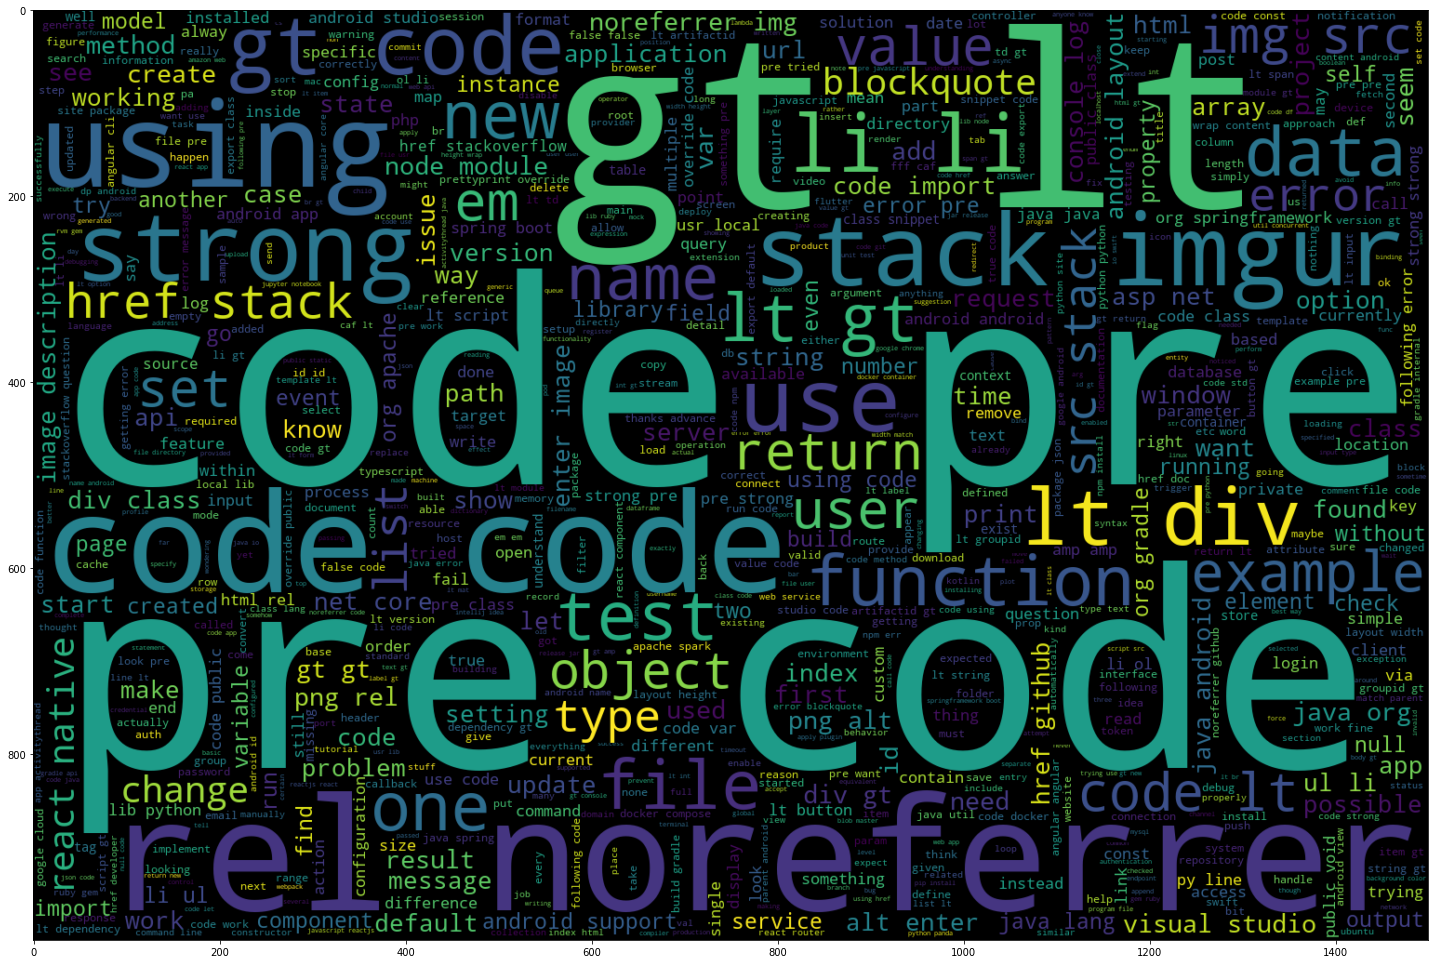

In [51]:
word_clouds((20, 20), preprocessed_train, 0)

WordCloud для вопросов LQ_CLOSE (target =1): Low-quality posts that were closed by the community without a single edit.

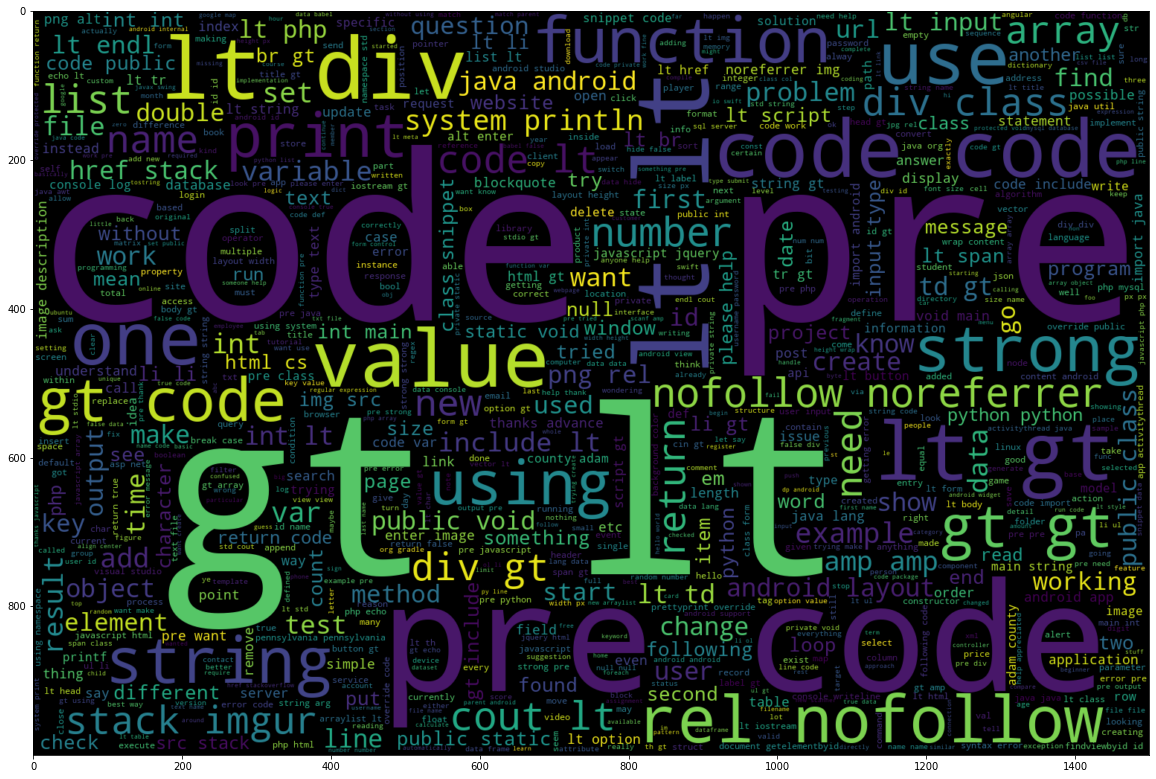

In [52]:
word_clouds((20, 20), preprocessed_train, 1)

WordCloud для вопросов LQ_EDIT (target =2): Low-quality posts with a negative score and with multiple community edits.

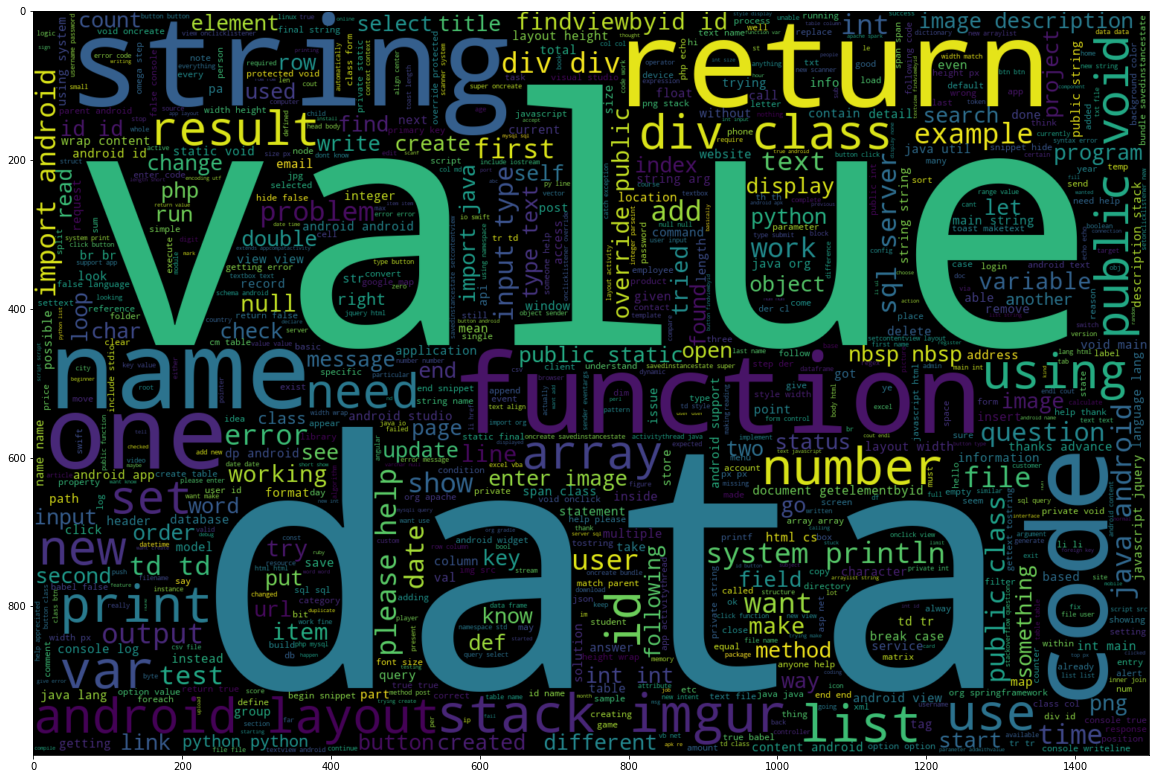

In [53]:
word_clouds((20, 20), preprocessed_train, 2)

In [55]:
visualize_train = copy.deepcopy(preprocessed_train)

Визуализируем частые слова в вопросах с высокой оценкой. Часто встречался html тег `p`. Скорее всего, это объясняется тем, что когда человек прикладывал к вопросу свою html разметку, в ней часто встречался этот тег, так как он является довольно часто используем. Вторым по популярности словом является слово `code`. Это может служить еще одним доказательством теории, что вопросы с высокой оценкой сопровождались примерами исходного кода.

In [57]:
visualize_train['temp_list'] = visualize_train['text'].apply(lambda x:str(x).split())

top = Counter([item for sublist in visualize_train['temp_list'].loc[visualize_train['target'] == 0] for item in sublist])
top_hq = pd.DataFrame(top.most_common(15))
top_hq.columns = ['Common_words','count']

fig = px.bar(top_hq, x='count',y='Common_words',title='Common words in High Quality posts',orientation='h',width=700,height=500,color='Common_words')
fig.show()

Визуализируем частые слова в закрытых вопросах. В них часто встречались круглые скобки. Возможно, это связано с тем, что люди прикладывали код с какими-то громоздкими конструкциями (по типу if (()&&()||()))

In [59]:
top = Counter([item for sublist in visualize_train['temp_list'].loc[visualize_train['target'] == 1] for item in sublist])
top_lq = pd.DataFrame(top.most_common(15))
top_lq.columns = ['Common_words','count']

fig = px.bar(top_lq, x='count',y='Common_words',title='Common words in Low Quality posts(Closed)',orientation='h',width=700,height=500,color='Common_words')
fig.show()

Заметим, что в открытых вопросах с низкой оценкой уже не встречается html тегов. Скорее всего, это связано с тем, что в веб разработке большое сообщество, и вопросы быстрее разрешаются или закрываются, а не остаются открытыми.

In [60]:
top = Counter([item for sublist in visualize_train['temp_list'].loc[visualize_train['target'] == 2] for item in sublist])
top_lq = pd.DataFrame(top.most_common(15))
top_lq.columns = ['Common_words','count']

fig = px.bar(top_lq, x='count',y='Common_words',title='Common words in Low Quality posts(Open)',orientation='h',width=700,height=500,color='Common_words')
fig.show()

## Embeddings

- one hot encoding
- word2vec обученную / самим обучить
- fasttext обученную / самим обучить
- tf-idf

In [ ]:
def get_model_vectors(corpus, model):    
    
  def get_vector(sentence):   
    word_tokens = word_tokenize(sentence)
    vector = 0
    for word in word_tokens:
      try: 
        vector += model.wv[word]
      except:
        continue
    return vector
    
  out_corpus = np.stack(corpus.apply(lambda x: get_vector(x)).to_numpy())
    
  return out_corpus

In [26]:
sentences = [row.split() for row in preprocessed_train['text']]     # список слов в каждой строке датафрейма
repeat_vocab = [item for sublist in sentences for item in sublist]  # все слова, которые встречаются в датафрейме
vocab = set(repeat_vocab)                                           # уберем повторяющиеся слова и получим словарь для датафрейма

#### Count Vectorizer

Обучим CountVectorizer и дадим ему на вход построенный словарь. То же самое проделаем для TFIDF

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 3), max_df=0.7, min_df=2, max_features=20, vocabulary=vocab)
count_vectorizer_data = count_vectorizer.fit_transform(train['text'])

#### Word2Vec

Создадим Word2Vec модель и обучим ее на словах из датафрейма, а затем преобразуем текст в вектора. То же самое проделаем для остальных gensim моделей в том числе предобученных.

In [ ]:
word2vec_model = gensim.models.Word2Vec(size=100, min_count=5, window=5)

In [ ]:
word2vec_model.build_vocab(sentences=sentences)

In [ ]:
word2vec_model.train(sentences=sentences, total_examples=len(sentences), epochs=10)

(43409989, 56475490)

In [ ]:
word2vec_vectors = get_model_vectors(preprocessed_train['text'], word2vec_model)

#### Word2Vec pretrained

In [ ]:
word2vec_model_pretrained = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/data/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
pretrained_word2vec_vectors = get_model_vectors(preprocessed_train['text'], word2vec_model_pretrained)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


#### FastText

In [27]:
fasttext_model = gensim.models.FastText(size=100, window=5, min_count=5)

In [28]:
fasttext_model.build_vocab(sentences=sentences)

In [29]:
fasttext_model.train(sentences=sentences, total_examples=len(sentences), epochs=10)

In [150]:
fasttext_vectors = get_model_vectors(preprocessed_train['text'], fasttext_model)

##### FastText vizualization

In [39]:
words = sorted(fasttext_model.wv.vocab, 
               key=lambda word: fasttext_model.wv.vocab[word].count,
               reverse=True)[:1000]

In [43]:
word_vectors = np.array([fasttext_model.wv.get_vector(vector) for vector in words])

In [45]:
pca = PCA(n_components=2)
pca.fit(word_vectors)
word_vectors_pca = pca.transform(word_vectors)
word_vectors_pca = (word_vectors_pca - word_vectors_pca.mean(axis=0)) / word_vectors_pca.std(axis=0)

In [47]:
def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=500, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [48]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

Figure(id='1159', ...)

Дальше всех от основной массы слов располагаются такие специфичные слова как расширения файлов, html теги, сокращения, доменная зона. Они употребляются в определенном контексте и имеют строгое однозначное значение, поэтому мало какие слова с ними пересекаются. Внутри основной массы слова неявно раделяются на две группы - термины из программирования (`void`, `mysql`, `lambda`, `await`) и 'обычные' слова (`know`, `everything`, `solve`, `simple`). Они близки друг к другу, так употрябляются в одном контексте вопросов по программированию. Если бы мы рассматривали более разноплановые тексты (например, вопросы по программированию, статьи про котиков, кулинарные рецепты), можно предположить, что 'обычные' слова находились бы далеко от терминов, связанных с программированием, так как намного реже употряблялись в одном контексте.

#### FastText pretrained

In [ ]:
fasttext_model_pretrained = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/data/wiki-news-300d-1M.vec')

In [ ]:
pretrained_fasttext_vectors = get_model_vectors(preprocessed_train['text'], fasttext_model_pretrained)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


#### TFIDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), max_df=0.5, min_df=3, max_features=20, vocabulary=vocab)
tfidf_data = tfidf_vectorizer.fit_transform(train['text'])

## Classical algorithms

Отберем несколько классических ML алгоритмов и попробуем обучить их на разных embeddings, чтобы затем выбрать наиболее подходящий для классификации. Оценивать качество алгоритмов будем по метрике accuracy. Чем выше accuracy, тем лучше.

In [151]:
y = preprocessed_train['target']

In [152]:
embeddings = {'count_vectorizer' :    (train_test_split(count_vectorizer_data, y, test_size=0.2, random_state=2020)),
              'tf_idf' :              (train_test_split(tfidf_data, y, test_size=0.2, random_state=2020)),
              'fasttext' :            (train_test_split(fasttext_vectors, y, test_size=0.2, random_state=2020)),
              'pretrained_fasttext' : (train_test_split(pretrained_fasttext_vectors, y, test_size=0.2, random_state=2020)),
              'word2vec' :            (train_test_split(word2vec_vectors, y, test_size=0.2, random_state=2020)),
              'pretrained_word2vec' : (train_test_split(pretrained_word2vec_vectors, y, test_size=0.2, random_state=2020)),
              } 
              # X_train, X_test, y_train, y_test

In [ ]:
classifiers = {'logreg': LogisticRegression(max_iter=1000),
               'svm' : SVC(),          
               'random_forest': RandomForestClassifier(),
               'decision_tree': DecisionTreeClassifier(),
               'ada_boost': AdaBoostClassifier(),
               'cat_boost': CatBoostClassifier(verbose=False)}

In [ ]:
best_classifiers = {'svm' : [],
                    'logreg': [],
                    'random_forest': [],
                    'decision_tree': [],
                    'ada_boost': [],
                    'cat_boost': []}

In [ ]:
for clf_name, clf in classifiers.items():
  for emb_name, embedding in embeddings.items():
    print(f'Fit algorithm {clf_name} with embedding {emb_name}')
    clf.fit(embedding[0], embedding[2])
    test_accuracy = accuracy_score(embedding[3], clf.predict(embedding[1]))
    best_classifiers[clf_name].append({ emb_name: test_accuracy})

Fit algorithm logreg with embedding count_vectorizer
Fit algorithm logreg with embedding tf_idf
Fit algorithm logreg with embedding fasttext


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fit algorithm logreg with embedding pretrained_fasttext


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fit algorithm logreg with embedding word2vec
Fit algorithm logreg with embedding pretrained_word2vec
Fit algorithm svm with embedding count_vectorizer
Fit algorithm svm with embedding tf_idf
Fit algorithm svm with embedding fasttext
Fit algorithm svm with embedding pretrained_fasttext
Fit algorithm svm with embedding word2vec
Fit algorithm svm with embedding pretrained_word2vec
Fit algorithm random_forest with embedding count_vectorizer
Fit algorithm random_forest with embedding tf_idf
Fit algorithm random_forest with embedding fasttext
Fit algorithm random_forest with embedding pretrained_fasttext
Fit algorithm random_forest with embedding word2vec
Fit algorithm random_forest with embedding pretrained_word2vec
Fit algorithm decision_tree with embedding count_vectorizer
Fit algorithm decision_tree with embedding tf_idf
Fit algorithm decision_tree with embedding fasttext
Fit algorithm decision_tree with embedding pretrained_fasttext
Fit algorithm decision_tree with embedding word2vec
Fi

In [ ]:
best_classifiers

{'ada_boost': [{'count_vectorizer': 0.7463541666666667},
  {'tf_idf': 0.7459375},
  {'fasttext': 0.7715625},
  {'pretrained_fasttext': 0.7182291666666667},
  {'word2vec': 0.7301041666666667},
  {'pretrained_word2vec': 0.7094791666666667}],
 'cat_boost': [{'count_vectorizer': 0.8183333333333334},
  {'tf_idf': 0.8230208333333333},
  {'fasttext': 0.86375},
  {'pretrained_fasttext': 0.8454166666666667},
  {'word2vec': 0.8354166666666667},
  {'pretrained_word2vec': 0.8377083333333334}],
 'decision_tree': [{'count_vectorizer': 0.7502083333333334},
  {'tf_idf': 0.7478125},
  {'fasttext': 0.7303125},
  {'pretrained_fasttext': 0.63},
  {'word2vec': 0.653125},
  {'pretrained_word2vec': 0.6198958333333333}],
 'logreg': [{'count_vectorizer': 0.8038541666666666},
  {'tf_idf': 0.8151041666666666},
  {'fasttext': 0.8455208333333334},
  {'pretrained_fasttext': 0.8441666666666666},
  {'word2vec': 0.7957291666666667},
  {'pretrained_word2vec': 0.8277083333333334}],
 'random_forest': [{'count_vectorizer'

Возьмем несколько алгоритмов, которые дали наилучшие результаты и попробуем подобрать для них лучшие параметры. И перед нами финалисты:


*   logreg with fasttext (0.849)
*   logreg with Pretrained FastText (0.844)
*   RandomForestClassifier with fasttext (0.834)
*   SVM with fasttext (0.859)
*   SVM with Pretrained Word2Vec (0.837)
*   Catboost with fasttext (0.86375)








#### Подбор параметров для лучших алгоритмов

Note: Для SVM не описан подбор параметров, так как методом проб и ошибок было выяснено, что лучше всего он работает со стандартными параметрами, а GridSearchCV занимает для него больше двух часов

##### Random Forest

In [ ]:
clf_rf = GridSearchCV(RandomForestClassifier(n_jobs=-1), 
                       param_grid={'max_depth': [None, 1, 2, 3, 4, 5], 
                                   'criterion': ['gini', 'entropy'],
                                   'min_samples_split': [2, 4, 6],
                                   'min_samples_leaf': [1, 2, 3]
                                   }, n_jobs=-1)

In [ ]:
clf_rf.fit(embeddings['fasttext'][0], embeddings['fasttext'][2])

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              rand

In [ ]:
clf_rf.best_params_, clf_rf.best_score_

({'criterion': 'entropy',
  'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 4},
 0.8394010416666667)

In [ ]:
random_forest_best_criterion = clf_rf.best_params_['criterion']
random_forest_best_max_depth = clf_rf.best_params_['max_depth']
random_forest_best_min_samples_leaf = clf_rf.best_params_['min_samples_leaf']
random_forest_best_min_samples_split = clf_rf.best_params_['min_samples_split']

##### Logistic regression

In [ ]:
clf_logr = GridSearchCV(LogisticRegression(max_iter=1000), 
                        param_grid={'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
                                    'random_state' : [42]}, n_jobs=-1)

In [ ]:
clf_logr.fit(embeddings['fasttext'][0], embeddings['fasttext'][2])

In [ ]:
clf_logr.best_params_, clf_logr.best_score_

({'penalty': 'l2', 'random_state': 42}, 0.8575260416666668)

In [ ]:
logr_fasttext_best_penalty = clf_logr.best_params_['penalty']

In [ ]:
clf_logr.fit(embeddings['pretrained_fasttext'][0], embeddings['pretrained_fasttext'][2])

In [ ]:
clf_logr.best_params_, clf_logr.best_score_

({'penalty': 'l2', 'random_state': 42}, 0.8472135416666667)

In [ ]:
logr_prefasttext_best_penalty = clf_logr.best_params_['penalty']

#### Запуск лучших алгоритмов с лучшими параметрами

##### SVM

In [ ]:
svm = SVC()

In [ ]:
svm_fasttext_pred = svm.fit(embeddings['fasttext'][0], embeddings['fasttext'][2]).predict(embeddings['fasttext'][1])

In [ ]:
accuracy_score(embeddings['fasttext'][3], svm_fasttext_pred)

0.8586458333333333

In [ ]:
print("Number of mislabeled points out of a total %d points : %d" 
      % (embeddings['fasttext'][1].shape[0], (embeddings['fasttext'][3] != svm_fasttext_pred).sum()))

Number of mislabeled points out of a total 9600 points : 1357


In [ ]:
svm_word2vec_pred = svm.fit(embeddings['pretrained_word2vec'][0], embeddings['pretrained_word2vec'][2]).predict(embeddings['pretrained_word2vec'][1])

In [ ]:
accuracy_score(embeddings['pretrained_word2vec'][3], svm_word2vec_pred)

0.8370833333333333

In [ ]:
print("Number of mislabeled points out of a total %d points : %d" 
      % (embeddings['pretrained_word2vec'][1].shape[0], (embeddings['pretrained_word2vec'][3] != svm_word2vec_pred).sum()))

Number of mislabeled points out of a total 9600 points : 1564


##### Random Forest

In [ ]:
random_forest = RandomForestClassifier(max_depth=random_forest_best_max_depth, criterion=random_forest_best_criterion, 
                                       min_samples_leaf=random_forest_best_min_samples_leaf, min_samples_split=random_forest_best_min_samples_split)
random_forest_pred = random_forest.fit(embeddings['fasttext'][0], embeddings['fasttext'][2]).predict(embeddings['fasttext'][1])

In [ ]:
accuracy_score(embeddings['fasttext'][3], random_forest_pred)

0.8352083333333333

In [ ]:
print("Number of mislabeled points out of a total %d points : %d" % (embeddings['fasttext'][1].shape[0], (embeddings['fasttext'][3] != random_forest_pred).sum()))

Number of mislabeled points out of a total 9600 points : 1582


##### Logreg

In [ ]:
logreg_fasttext = LogisticRegression(max_iter=1000, penalty=logr_fasttext_best_penalty, random_state=42)
logreg_fasttext_pred = logreg_fasttext.fit(embeddings['fasttext'][0], embeddings['fasttext'][2]).predict(embeddings['fasttext'][1])

In [ ]:
accuracy_score(embeddings['fasttext'][3], logreg_fasttext_pred)

0.8479166666666667

In [ ]:
print("Number of mislabeled points out of a total %d points : %d" % (embeddings['fasttext'][1].shape[0], (embeddings['fasttext'][3] != logreg_fasttext_pred).sum()))

Number of mislabeled points out of a total 9600 points : 1460


In [ ]:
logreg_fasttext = LogisticRegression(max_iter=1000, penalty=logr_prefasttext_best_penalty, random_state=42)
logreg_prefasttext_pred = logreg_prefasttext.fit(embeddings['pretrained_fasttext'][0], embeddings['pretrained_fasttext'][2]).predict(embeddings['pretrained_fasttext'][1])

In [ ]:
accuracy_score(embeddings['pretrained_fasttext'][3], logreg_prefasttext_pred)

0.8441666666666666

In [ ]:
print("Number of mislabeled points out of a total %d points : %d" 
      % (embeddings['pretrained_fasttext'][1].shape[0], (embeddings['pretrained_fasttext'][3] != logreg_prefasttext_pred).sum()))

Number of mislabeled points out of a total 9600 points : 1496


##### Catboost

In [155]:
cat_boost = CatBoostClassifier(iterations=2000, verbose=False)

In [156]:
cat_boost_pred = cat_boost.fit(embeddings['fasttext'][0], embeddings['fasttext'][2]).predict(embeddings['fasttext'][1])

In [157]:
accuracy_score(embeddings['fasttext'][3], cat_boost_pred)

0.8680208333333334

Как видим, подбор параметров позволил улучшить результаты для алгоритма Random Forest. Все остальные алгоритмы лучше всего работают со своими дефолтными параметрами. Самый лучший результат показал алгоритм Catboost - почти 0.87 💪. При помощи него в дальнейшем и будем предсказывать классы для наших тестовых (неразмеченных) данных. 

#### LDA

In [ ]:
lda = LatentDirichletAllocation(n_components=5, max_iter=15,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=2020)

In [ ]:
count_data_lda = lda.fit_transform(count_vectorizer_data)

In [ ]:
LDAvis_prepared = sklearn_lda.prepare(lda, count_vectorizer_data, count_vectorizer)

Латентное размещение Дирихле позволяет разделять данные в неявные группы. Данные были разделены на пять групп. Среди них три имеют близкое расположение и пересекаются, а две заметно удалены от них. В одну группу попали вопросы о базах данных (судя по словам `id`, `table`, `data`, `sql`, `database`). В другую вопросы по С (судя по словам `int`, `char`, `printf`, `void`), возможно по низкоуровневым языкам программирования. В остальные группы были отнесены общие вопросы по распространенным языкам, так как этих группах встречаются слова `android`, `java`, `array`. При этом одна из групп похожа на вопросы по веб-разработке, так как в ней встречаются слова из html (`gt` - greater-than sign, `lt` - less-than sign, `div`, `href`)

In [ ]:
pyLDAvis.display(LDAvis_prepared)

#### Classification with features


Попробуем еще учесть для классификации созданные нами дополнительные признаки. В основном алгоритмы лучше всего работали с эмбедингом fasttext, поэтому разделим датафрейм с новыми фичами на test и train по этому эмбедингу, чтобы предсказать test по тем же данным. Возьмем те же алгоритмы, что и для текстовой классификации и выберем из них то, который дает самый высокий accuracy.

In [ ]:
emb_y_train = pd.DataFrame(embeddings['fasttext'][2])
emb_y_test = pd.DataFrame(embeddings['fasttext'][3])

In [ ]:
train_with_features.drop(columns=['Id', 'Body', 'Tags', 'Title', 'Tags_list'], inplace=True)

In [ ]:
train_features = train_with_features[train_with_features.index.isin(emb_y_train.index)]
test_features = train_with_features[train_with_features.index.isin(emb_y_test.index)]

In [ ]:
y_train_features = train_features['target']
y_test_features = test_features['target']
X_train_features = copy.deepcopy(train_features)
X_test_features = copy.deepcopy(test_features)

X_train_features.drop(columns=['target'], inplace=True)
X_test_features.drop(columns=['target'], inplace=True)

In [ ]:
classifiers_features = {'logreg': LogisticRegression(max_iter=1000),
               'svm' : SVC(),          
               'random_forest': RandomForestClassifier(),
               'decision_tree': DecisionTreeClassifier(),
               'ada_boost': AdaBoostClassifier(),
               'cat_boost': CatBoostClassifier(verbose=False)}

In [ ]:
best_classifiers_features = {'svm' : [],
                             'logreg': [],
                             'random_forest': [],
                             'decision_tree': [],
                             'ada_boost': [],
                             'cat_boost': []}

In [ ]:
for clf_name, clf in classifiers_features.items():
  print(f'Fit algorithm {clf_name}')
  clf.fit(X_train_features, y_train_features)
  test_accuracy = accuracy_score(y_test_features, clf.predict(X_test_features))
  best_classifiers_features[clf_name].append(test_accuracy)

In [ ]:
best_classifiers_features

{'ada_boost': [0.57375],
 'cat_boost': [0.6283333333333333],
 'decision_tree': [0.49614583333333334],
 'logreg': [0.5191666666666667],
 'random_forest': [0.605],
 'svm': [0.48270833333333335]}

Лучше всего себя показали классификаторы Random Forest и Catboost, значит попробуем добавить каждый из них в ансамбль. Предскажем классы по тексту при помощи SVM, а классы по дополнительным фичам при помощи Random Forest и Catboost, и методом голосования решим, к какому классу относится вопрос. Сложим вероятности, которые предсказывают каждый из классификаторов, и дадим классификатору по фичам меньший вес, так как он ошибается чаще.

In [ ]:
random_forest_features = RandomForestClassifier()

In [ ]:
rf_pred_proba = random_forest_features.fit(X_train_features, y_train_features).predict_proba(X_test_features)

In [ ]:
svm = SVC(probability=True)

In [ ]:
svm_pred_proba = svm.fit(embeddings['fasttext'][0], embeddings['fasttext'][2]).predict_proba(embeddings['fasttext'][1])

In [ ]:
def find_best_class(features_pred, text_pred):
  pred_classes = []
  for i in range(len(features_pred)):
    # возьмем вероятности классов, предсказанных по новым фичам с весом 0.1, а по тексту с весом 0.9
    probabilities = [(0.1 * x + 0.9 * y) for x, y in zip(features_pred[i], text_pred[i])]
    pred_classes.append(probabilities.index(max(probabilities)))
  return pred_classes

In [ ]:
ens_pred_classes = find_best_class(rf_pred_proba, svm_pred_proba)

In [ ]:
accuracy_score(embeddings['fasttext'][3], ens_pred_classes)

0.8614583333333333

In [ ]:
print("Number of mislabeled points out of a total %d points : %d" % (embeddings['fasttext'][1].shape[0], (embeddings['fasttext'][3] != ens_pred_classes).sum()))

Number of mislabeled points out of a total 9600 points : 1692


In [ ]:
cat_boost_features = CatBoostClassifier(verbose=False)

In [ ]:
cat_boost_features_pred_proba = cat_boost_features.fit(X_train_features, y_train_features).predict_proba(X_test_features)

In [ ]:
cat_svm_pred_classes = find_best_class(cat_boost_features_pred_proba, svm_pred_proba)

In [ ]:
accuracy_score(embeddings['fasttext'][3], cat_svm_pred_classes)

0.8617708333333334

Нам немного удалось улучшить результаты для SVM классификатора, но он все равно уступает CatBoost. Вы скажете, что можно было попробовать два классификатора CatBoost, раз они дают самые хорошие результаты. И мы попробовали, но стало только хуже ☹️

## Neural networks

Теперь попробуем классифицировать вопросы при помощи нейросетей. Попробуем два варианта - построим нейросесть отдельно для колонок `Body`, `Tags`, `Title` и для объединенного текста. 

In [97]:
train = pd.read_parquet('/content/drive/My Drive/data/train.parquet')
train = train.reset_index()

In [98]:
text_columns = ['Body', 'Tags', 'Title']
target_column = 'target'

In [99]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [100]:
train['Body'] = train['Body'].apply(str).apply(str.lower).apply(tokenizer.tokenize).apply(' '.join)
train['Title'] = train['Title'].apply(str).apply(str.lower).apply(tokenizer.tokenize).apply(' '.join)
train['Tags'] = train['Tags'].apply(str).apply(str.lower).apply(tokenizer.tokenize).apply(' '.join)

In [101]:
token_counts = Counter(token for col in text_columns
                             for item in train[col]
                             for token in item.split())

In [102]:
min_count = 10

tokens = [token for token, count in token_counts.items() if count >= min_count]

In [103]:
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

Vocabulary size: 24753


In [104]:
token_to_id = dict(map(reversed, enumerate(tokens)))

In [105]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [106]:
data_train, data_val = train_test_split(train, test_size=0.2, random_state=2020)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  38400
Validation size =  9600


In [107]:
def make_batch(data, max_len=None, word_dropout=0):
  batch = {}
  batch["Title"] = as_matrix(data["Title"].values, max_len)
  batch["Body"] = as_matrix(data["Body"].values, max_len)
  batch["Tags"] = as_matrix(data["Tags"].values, max_len)
  batch[target_column] = data[target_column].values
    
  return batch

In [108]:
def build_model(n_tokens=len(tokens)):
    
    l_title = L.Input(shape=[None], name="Title")
    l_body = L.Input(shape=[None], name="Body")
    l_tags = L.Input(shape=[None], name="Tags")
    
    emb = L.Embedding(len(tokens), 128)

    l_title_emb = emb(l_title)
    l_title_emb = L.Dense(128)(l_title_emb)
    l_title_emb = L.GlobalMaxPool1D()(l_title_emb) 
    l_title_emb = L.Flatten()(l_title_emb)

    l_tags_emb = emb(l_tags)
    l_tags_emb = L.Dense(128)(l_tags_emb)
    l_tags_emb = L.GlobalMaxPool1D()(l_tags_emb)
    l_tags_emb = L.Flatten()(l_tags_emb)

    l_body_emb = emb(l_body)
    l_body_emb = L.Dense(128)(l_body_emb)
    l_body_emb = L.GlobalMaxPool1D()(l_body_emb)
    l_body_emb = L.Flatten()(l_body_emb)
      

    l_all = L.Concatenate()([l_body_emb, l_title_emb, l_tags_emb])   
    l_all = L.Flatten()(l_all)
    l_all = L.Dense(128)(l_all)
    output_layer = L.Dense(1)(l_all)
    
    model = keras.models.Model(inputs=[l_title, l_body, l_tags], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error', 'accuracy'])
    return model

In [109]:
model = build_model()
model.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
Title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
Tags (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, None, 128)    3168384     Title[0][0]                      
                                                                 Tags[0][0]           

In [110]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
  while True:
    indices = np.arange(len(data))
    if shuffle:
      indices = np.random.permutation(indices)

    for start in range(0, len(indices), batch_size):
      batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
      target = batch.pop(target_column)
      yield batch, target
        
    if not cycle: break

In [111]:
batch_size = 256
epochs = 10            
steps_per_epoch = 100

In [112]:
model = build_model()

model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,                  
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
100/100 [==============================] - 286s 3s/step - loss: 0.3332 - mean_absolute_error: 0.4407 - accuracy: 0.4737 - val_loss: 0.0925 - val_mean_absolute_error: 0.2329 - val_accuracy: 0.5853
Epoch 2/10
100/100 [==============================] - 294s 3s/step - loss: 0.0758 - mean_absolute_error: 0.2083 - accuracy: 0.6063 - val_loss: 0.0818 - val_mean_absolute_error: 0.2145 - val_accuracy: 0.5947
Epoch 3/10
100/100 [==============================] - 280s 3s/step - loss: 0.0667 - mean_absolute_error: 0.1949 - accuracy: 0.6110 - val_loss: 0.0792 - val_mean_absolute_error: 0.2126 - val_accuracy: 0.6012
Epoch 4/10
100/100 [==============================] - 299s 3s/step - loss: 0.0485 - mean_absolute_error: 0.1645 - accuracy: 0.6346 - val_loss: 0.0804 - val_mean_absolute_error: 0.2132 - val_accuracy: 0.5982
Epoch 5/10
100/100 [==============================] - 273s 3s/step - loss: 0.0423 - mean_absolut

In [ ]:
sentences = preprocessed_train['text'].values
y = preprocessed_train['target'].values

In [ ]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2, random_state=2020)

In [ ]:
max_features = 20000
maxlen = 200
embed_size = 300

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
model = Sequential()
model.add(L.Embedding(input_dim=max_features, 
                      output_dim=embed_size, 
                      input_length=maxlen))

model.add(L.Conv1D(128, 5, activation='relu'))
model.add(L.Conv1D(64, 5, activation='sigmoid'))
model.add(L.Conv1D(32, 5, activation='relu'))
model.add(L.GlobalMaxPooling1D())
model.add(L.Flatten())
model.add(L.Dense(3))
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 200, 300)          6000000   
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 196, 128)          192128    
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 192, 64)           41024     
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 188, 32)           10272     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 32)                0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 3)                

In [96]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    steps_per_epoch=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=128)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/20
100/100 [==============================] - 108s 1s/step - loss: 0.0491 - accuracy: 0.3203 - val_loss: 0.0832 - val_accuracy: 0.2601
Epoch 2/20
100/100 [==============================] - 109s 1s/step - loss: 0.0500 - accuracy: 0.3027 - val_loss: 0.0843 - val_accuracy: 0.3567
Epoch 3/20
100/100 [==============================] - 108s 1s/step - loss: 0.0516 - accuracy: 0.3058 - val_loss: 0.0823 - val_accuracy: 0.3625
Epoch 4/20
100/100 [==============================] - 109s 1s/step - loss: 0.0352 - accuracy: 0.3209 - val_loss: 0.0819 - val_accuracy: 0.2862
Epoch 5/20
100/100 [==============================] - 108s 1s/step - loss: 0.0372 - accuracy: 0.3219 - val_loss: 0.0817 - val_accuracy: 0.4095
Epoch 6/20
100/100 [==============================] - 109s 1s/step - loss: 0.0369 - accuracy: 0.3166 - val_loss: 0.0816 - val_accuracy: 0.2695
Epoch 7/20
100/100 [==============================] - 108s 1s/step - loss: 0.0258 - accuracy: 0.3215 - val_loss: 0.0833 - val_accuracy: 0.3001

Результаты уступают тем, что получились у классических алгоритмов машинного обучения. Лучше себя показала нейросеть, которая тренировалась на каждой колонке по отдельности. Где-то на просторах интернета я прочитала, что для классификации текста лучше всего подходит LSTM и GRU слои, но они тоже не улучшили результаты. К тому же обучались другие архитектуры намного дольше и не улучшали результатов. 

## Create test predictions

In [158]:
test = pd.read_parquet('/content/drive/My Drive/data/test.parquet')
test = test.reset_index()

Apply some preprocessing

In [159]:
test['Tags'] = test['Tags'].apply(remove_html_brackets)

In [160]:
test['Tags_list'] = test['Tags'].apply(lambda x: x.split())

In [161]:
preprocessed_test = columns_preprocess(test)

In [162]:
preprocessed_test['text'] = preprocessed_test['text'].apply(text_preprocess)

In [163]:
preprocessed_test.head()

,text
0,math machine learning artificial intelligence ...
1,io swift swift xcode nserror value type error ...
2,jenkins jenkins pipeline lint jenkins pipeline...
3,javascript cs mobile safari fastclick j fastcl...
4,android testing appium katalon studio loop tes...


Сделаем эмбединги

In [164]:
fasttext_test_vectors = get_model_vectors(preprocessed_test['text'], fasttext_model)

Запустим лучший алгоритм

In [165]:
cat_boost_pred_test = cat_boost.predict(fasttext_test_vectors)

In [168]:
predicted_test = pd.DataFrame(data=cat_boost_pred_test, columns=['Predicted'])

In [170]:
predicted_test.to_csv('submission.csv')

### Немного выводов

Stack Overflow - это один из самых полезных и популярных сайтов в сети интернет. Хотя этот сайт и позволяет найти ответы на множество типичных вопросов, связанных с программированием, они не всегда находят одобрения, и могут быть жестоко закрыты или так и остаться неотвеченными и утонуть в недрах других более востребованных вопросов. 

Как было замечено, не всегда удачный препроцессинг и очистка данных дают хорошие результаты. Для используемых данных была проведена минимальная обработка, с учетом специфики рассматриваемой области. Действительно, в данном случае не представляется разумным очищать текст, например, от коротких слов (меньше трех или четерых символов), казалось бы не несущих смысла в обычных текстах. В программировании они могут являться зарезервированными словами, используемыми для написания кода. Помимо этого, добавление новых фич (feature engeneering) не привело к значительному улучшению точности алгоритма, но все равно прибавило немного accuracy. 

Несмотря на популярность нейросетей и их применимость для многих задач, в данной лабораторной нейросети показали себя хуже, чем классические алгоритмы, хотя было сделано множество попыток использовать разные архитектуры.

Тем не менее, можно полагать, что данные удалось успешно классифицировать. Кроме того, в данной лабораторной были опробованы различные методы классификации текстовых данных, что позволило выбрать из них наилучший. А предварительный анализ данных позволил открыть интересные статистики и паттерны.